In [ ]:
"""
日本語URL
https://qiskit.org/textbook/ja/ch-algorithms/bernstein-vazirani.html
英語URL
https://qiskit.org/textbook/ch-algorithms/bernstein-vazirani.html
"""

# ベルンシュタイン・ヴァジラニ アルゴリズム
ベルンシュタイン・ヴァジラニ アルゴリズムは、前節で取り上げたドイチ・ジョザ アルゴリズムの拡張として見ることができます。このアルゴリズムは、ドイチ・ジョザ問題と比較して、より複雑な問題の計算ツールとして量子コンピューターを使用することに利点があることを示しました。

* 入力：ビット列x
* ビット列s（これがどんなビット列か見つけたい）
* 関数fは、xとsの内積を返す。つまり、
  - f(x) = s*x(mod 2)

## 古典的解法
x = "0001"

x = "0010"

x = "0100"

x = "1000"

と、1つひとつ入力していけば、sが判明する。

よって、ビット長nとすると、fをn回呼び出せば良いので、計算量はO(n)

## 量子的解法
f(x)の呼び出しを1回で解くことができる

1. 入力量子ビットを|0>に、出力量子ビットを|->に初期化する
2. アダマールゲートを入力量子ビットに適用
3. オラクル(f)をクエリ
4. 入力量子ビットに再度アダマールゲートを適用
5. 測定（入力量子ビットがsになっている）


# 2. 具体例

In [1]:
from qiskit_textbook.widgets import bv_widget
bv_widget(2, "11")

HTMLMath(value='$$ |00\\rangle = |00\\rangle $$')

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\xce\x00\x00\x00\xcc\x08\x06\x00\x00\x00;\xd7\x9c…

HTMLMath(value='$$ |00\\rangle = |00\\rangle $$')

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\xce\x00\x00\x00\xcc\x08\x06\x00\x00\x00;\xd7\x9c…

# 3. Qiskitを用いた実装

ここで、 s=011 の3量子ビットの関数について、Qiskitでのベルンシュタイン・ヴァジラニ アルゴリズムの実装を見ていきましょう。

In [25]:
import matplotlib.pyplot as plt
import numpy as np

from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile, assemble

from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor

In [18]:
n = 3  # qubitsの数
s = "011"  # 隠されたビット列

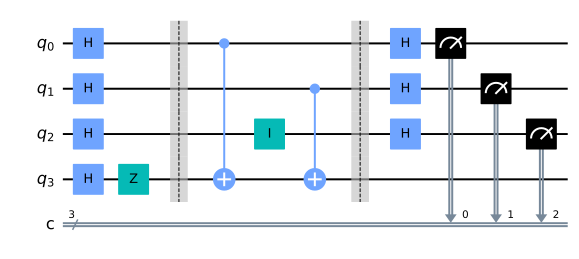

In [20]:
"""Bernstein-Vazirani algorithm
"""
bv_qc = QuantumCircuit(n+1, n)

# 初期化
# put ancilla in state |->
bv_qc.h(n)
bv_qc.z(n)

# 重ね合わせ状態にする
for i in range(n):
    bv_qc.h(i)
bv_qc.barrier()

# Apply the inner-product oracle（内積オラクルを適用）
rs = s[::-1]  # reverse
for q in range(n):
    if rs[q] == "0":
        bv_qc.i(q)  # IGate (Identity Gate)
    else:
        bv_qc.cx(q, n)
bv_qc.barrier()

# Apply Hadamard gates after querying the oracle
for i in range(n):
    bv_qc.h(i)

# Measurement
for i in range(n):
    bv_qc.measure(i, i)

bv_qc.draw()

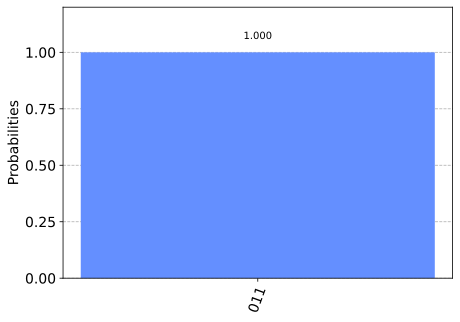

In [23]:
"""シミュレーションでの実験
"011"が100%の確率で測定できる
"""
# use local simulator
aer_sim = Aer.get_backend("qasm_simulator")
shots = 1024
qobj = assemble(bv_qc)
results = aer_sim.run(qobj, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)

In [24]:
"""実デバイスでの実験
"""
# Load our saved IBMQ accounts and get the least busy backend device with less than or equal to 5 qubits
IBMQ.load_account()
provider = IBMQ.get_provider(hub="ibm-q")
provider.backends()
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits <= 5 and x.configuration().n_qubits >= 2 and not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

least busy backend:  ibmqx2


In [27]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
shots = 1024
transpiled_bv_qc = transpile(bv_qc, backend)
job = backend.run(transpiled_bv_qc, shots=shots)

job_monitor(job, interval=2)

Job Status: job has successfully run


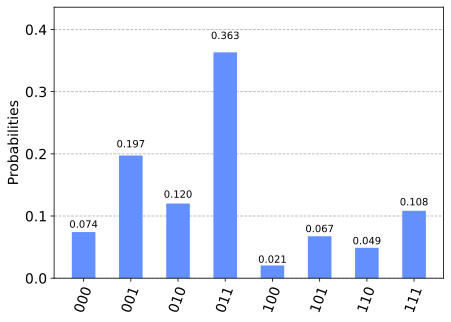

In [28]:
# Get the results from the computation
# 殆どの結果は"011"になる。他の結果は量子計算の誤差によるもの。
results = job.result()
answer = results.get_counts()

plot_histogram(answer)

In [29]:
print(answer)

{'000': 76, '001': 202, '010': 123, '011': 372, '100': 21, '101': 69, '110': 50, '111': 111}


# 4. 演習

In [31]:
from qiskit_textbook.widgets import bv_widget
bv_widget(3, "011", hide_oracle=False)

HTMLMath(value='$$ |000\\rangle = |000\\rangle $$')

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\xce\x00\x00\x01\x08\x08\x06\x00\x00\x00\x17\xd9\…

In [37]:
"""秘密の文字列  s=1011  の場合を実装してください。結果は期待通りでしたか？説明してみてください。
"""
def make_bv_qc(s):
    """ベルンシュタイン・ヴァジラニ回路を作成する
    Args:
        s(string): 秘密の文字列
    Returns
        qc(QuantumCircuit): ベルンシュタイン・ヴァジラニ回路
    """
    n = len(s)
    qc = QuantumCircuit(n+1, n)

    # 初期化
    qc.h(n)
    qc.z(n)

    for i in range(n):
        qc.h(i)
    qc.barrier()

    # 内積回路
    rs = s[::-1]  # 文字列反転
    for i in range(n):
        if rs[i] == "0":
            qc.i(i)  # Identity-Gate
        else:
            qc.cx(i, n)
    qc.barrier()

    # 再度、Hゲートを通す
    for i in range(n):
        qc.h(i)
    
    # 測定
    for i in range(n):
        qc.measure(i, i)
    
    return qc

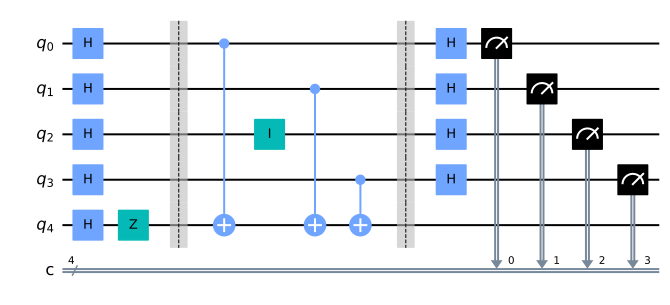

In [38]:
s = "1011"

bv_qc_1011 = make_bv_qc(s)

bv_qc_1011.draw()

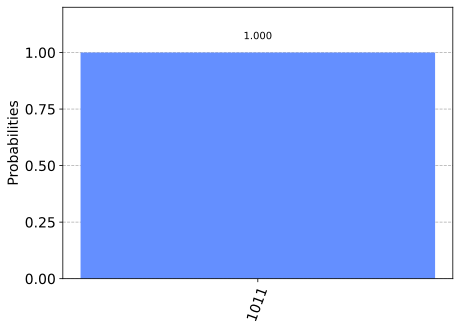

In [39]:
"""シミュレーションでの実験
"1011"が100%の確率で測定できる
"""
# use local simulator
aer_sim = Aer.get_backend("aer_simulator")
shots = 1024
qobj = assemble(bv_qc_1011)
results = aer_sim.run(qobj, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)

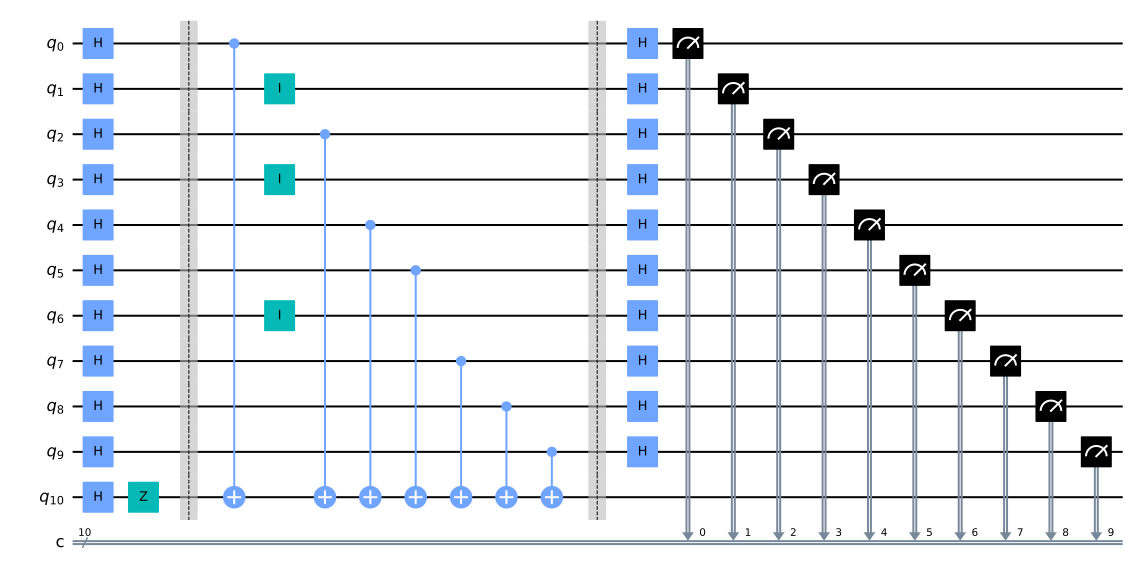

In [40]:
"""秘密の文字列  s=1110110101  の場合を実装してください。結果は期待通りでしたか？説明してみてください。
"""
s = "1110110101"
bv_qc_1110110101 = make_bv_qc(s)
bv_qc_1110110101.draw()

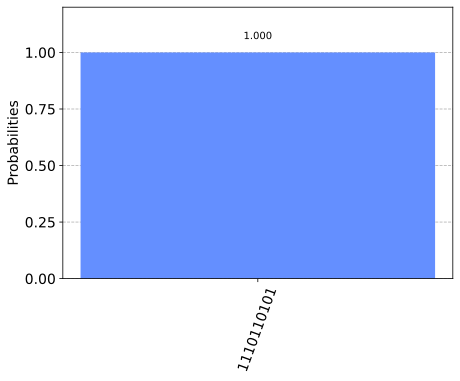

In [41]:
# シミュレーション実行
backend = Aer.get_backend("aer_simulator")
shots = 1024
qobj = assemble(bv_qc_1110110101)
results = backend.run(qobj, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)